# Training and Validation (Illustrative)

In [3]:
import os
import sys
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

# Ensure project root is on sys.path so `surgical_phase_tool` is importable
project_root = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
if project_root not in sys.path:
    sys.path.append(project_root)

from surgical_phase_tool.config import (
    TRAIN_MANIFEST, BATCH_SIZE, NUM_WORKERS, DEVICE, LEARNING_RATE, WEIGHT_DECAY,
    PHASE_LOSS_WEIGHT, TOOL_LOSS_WEIGHT, SEED
)
from surgical_phase_tool.config_loader import set_global_seed
from surgical_phase_tool.dataset import MultiTaskWindowDataset, PHASE_TO_ID, TOOL_COLUMNS, ID_TO_PHASE
from surgical_phase_tool.models.resnet_multitask import PhaseToolNet
from surgical_phase_tool.hierarchy.phase_tool_mask import build_phase_tool_mask, apply_phase_mask_to_logits
from surgical_phase_tool.metrics import phase_metrics, tool_metrics

set_global_seed(SEED)

full_train_dataset = MultiTaskWindowDataset(TRAIN_MANIFEST, is_train=True)
val_size = max(1, int(0.1 * len(full_train_dataset)))
train_size = len(full_train_dataset) - val_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=False)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=False)

model = PhaseToolNet(backbone_name='resnet18', pretrained=True).to(DEVICE)

phase_counts = np.zeros(len(PHASE_TO_ID), dtype=np.int64)
for _, phase_target, _ in DataLoader(full_train_dataset, batch_size=64, shuffle=False, num_workers=NUM_WORKERS):
    ids = phase_target.argmax(dim=-1).numpy()
    for i in ids:
        phase_counts[i] += 1
phase_counts = np.maximum(phase_counts, 1)
inv_freq = 1.0 / phase_counts
weights = inv_freq / inv_freq.mean()
phase_class_weights = torch.tensor(weights, dtype=torch.float32).to(DEVICE)

phase_criterion = nn.CrossEntropyLoss(weight=phase_class_weights)
tool_criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

phase_tool_mask = build_phase_tool_mask().to(DEVICE)

history = {
    'epoch': [],
    'train_loss': [],
    'val_loss': [],
    'val_phase_acc': [],
    'val_tool_micro_no_mask': [],
    'val_tool_micro_with_mask': [],
}
short_epochs = 3
len(train_dataset), len(val_dataset), short_epochs

(2661, 295, 3)

In [4]:
for epoch in range(1, short_epochs + 1):
    model.train()
    running_loss = 0.0
    for frames, phase_target, tool_target in train_loader:
        frames = frames.to(DEVICE)
        phase_target = phase_target.to(DEVICE)
        tool_target = tool_target.to(DEVICE)
        optimizer.zero_grad()
        phase_logits, tool_logits = model(frames)
        phase_loss = phase_criterion(phase_logits, phase_target.argmax(dim=-1))
        gt_phase_ids = phase_target.argmax(dim=-1)
        gt_phase_one_hot = torch.nn.functional.one_hot(gt_phase_ids, num_classes=len(PHASE_TO_ID)).float()
        masked_tool_logits = apply_phase_mask_to_logits(tool_logits, gt_phase_one_hot, phase_tool_mask, hard=True)
        tool_loss = tool_criterion(masked_tool_logits, tool_target)
        loss = PHASE_LOSS_WEIGHT * phase_loss + TOOL_LOSS_WEIGHT * tool_loss
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * frames.size(0)
    train_loss = running_loss / len(train_loader.dataset)

    model.eval()
    all_phase_logits, all_phase_targets = [], []
    all_tool_logits, all_tool_targets = [], []
    total_val_loss = 0.0
    with torch.no_grad():
        for frames, phase_target, tool_target in val_loader:
            frames = frames.to(DEVICE)
            phase_target = phase_target.to(DEVICE)
            tool_target = tool_target.to(DEVICE)
            phase_logits, tool_logits = model(frames)
            phase_loss = phase_criterion(phase_logits, phase_target.argmax(dim=-1))
            gt_phase_ids = phase_target.argmax(dim=-1)
            gt_phase_one_hot = torch.nn.functional.one_hot(gt_phase_ids, num_classes=len(PHASE_TO_ID)).float()
            masked_tool_logits = apply_phase_mask_to_logits(tool_logits, gt_phase_one_hot, phase_tool_mask, hard=True)
            tool_loss = tool_criterion(masked_tool_logits, tool_target)
            loss = PHASE_LOSS_WEIGHT * phase_loss + TOOL_LOSS_WEIGHT * tool_loss
            total_val_loss += loss.item() * frames.size(0)
            all_phase_logits.append(phase_logits.cpu())
            all_phase_targets.append(phase_target.cpu())
            all_tool_logits.append(tool_logits.cpu())
            all_tool_targets.append(tool_target.cpu())
    all_phase_logits = torch.cat(all_phase_logits, dim=0)
    all_phase_targets = torch.cat(all_phase_targets, dim=0)
    all_tool_logits = torch.cat(all_tool_logits, dim=0)
    all_tool_targets = torch.cat(all_tool_targets, dim=0)
    phase_acc, _, _ = phase_metrics(all_phase_logits, all_phase_targets)
    tool_no_mask = tool_metrics(all_tool_logits, all_tool_targets, threshold=0.5)
    phase_probs = all_phase_logits.softmax(dim=-1)
    masked_logits_pred = apply_phase_mask_to_logits(all_tool_logits, phase_probs, phase_tool_mask.to(all_tool_logits.device), hard=False)
    tool_with_mask = tool_metrics(masked_logits_pred, all_tool_targets, threshold=0.5)
    val_loss = total_val_loss / len(val_loader.dataset)

    history['epoch'].append(epoch)
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['val_phase_acc'].append(phase_acc)
    history['val_tool_micro_no_mask'].append(tool_no_mask['f1_micro'])
    history['val_tool_micro_with_mask'].append(tool_with_mask['f1_micro'])

history

{'epoch': [1, 2, 3],
 'train_loss': [0.514879636162712, 0.21906298204937272, 0.14237423468421764],
 'val_loss': [0.1019221112992362, 0.053591911433367216, 0.09167736304324058],
 'val_phase_acc': [np.float64(0.9355932203389831),
  np.float64(0.9661016949152542),
  np.float64(0.9627118644067797)],
 'val_tool_micro_no_mask': [0.4979969183359014,
  0.4955315870570108,
  0.5174114021571649],
 'val_tool_micro_with_mask': [0.8936825885978429,
  0.9103235747303544,
  0.9189522342064715]}

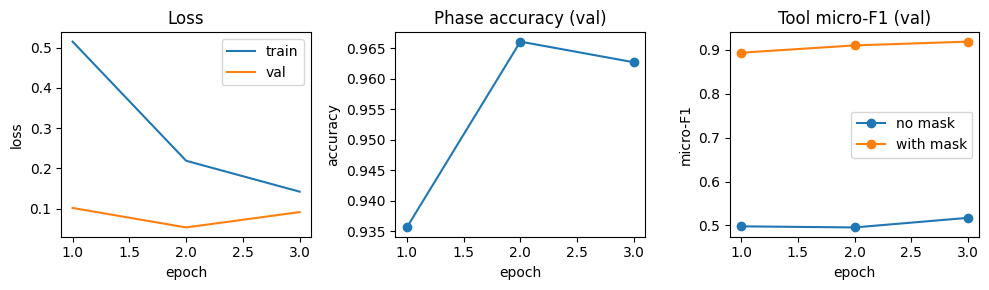

In [5]:
epochs = history['epoch']
plt.figure(figsize=(10, 3))
plt.subplot(1, 3, 1)
plt.plot(epochs, history['train_loss'], label='train')
plt.plot(epochs, history['val_loss'], label='val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss')
plt.legend()
plt.subplot(1, 3, 2)
plt.plot(epochs, history['val_phase_acc'], marker='o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Phase accuracy (val)')
plt.subplot(1, 3, 3)
plt.plot(epochs, history['val_tool_micro_no_mask'], label='no mask', marker='o')
plt.plot(epochs, history['val_tool_micro_with_mask'], label='with mask', marker='o')
plt.xlabel('epoch')
plt.ylabel('micro-F1')
plt.title('Tool micro-F1 (val)')
plt.legend()
plt.tight_layout()
plt.show()

In [6]:
import pandas as pd

final_epoch = history['epoch'][-1] if history['epoch'] else None
if final_epoch is not None:
    final_phase_acc = history['val_phase_acc'][-1]
    print(f'Final validation phase accuracy (epoch {final_epoch}): {final_phase_acc:.4f}')
    
    micro_summary = pd.DataFrame({
        'metric': ['precision_micro', 'recall_micro', 'f1_micro'],
        'no_mask': [
            tool_no_mask['precision_micro'],
            tool_no_mask['recall_micro'],
            tool_no_mask['f1_micro'],
        ],
        'with_mask': [
            tool_with_mask['precision_micro'],
            tool_with_mask['recall_micro'],
            tool_with_mask['f1_micro'],
        ],
    })
    display(micro_summary)
    
    per_tool_df = pd.DataFrame({
        'tool': TOOL_COLUMNS,
        'f1_no_mask': tool_no_mask['f1_per'],
        'f1_with_mask': tool_with_mask['f1_per'],
    })
    per_tool_df['delta_f1'] = per_tool_df['f1_with_mask'] - per_tool_df['f1_no_mask']
    per_tool_df.set_index('tool', inplace=True)
    per_tool_df
else:
    print('History is empty; run the training cell first.')

Final validation phase accuracy (epoch 3): 0.9627


,metric,no_mask,with_mask
0,precision_micro,0.517411,0.918952
1,recall_micro,0.517411,0.918952
2,f1_micro,0.517411,0.918952


Example 0: true=Preparation, pred=Preparation
  Top tools (unmasked):
    Scissor: 1.000
    Clip-Applicator: 1.000
    HF-Coagulation-Probe: 1.000
    Suction-Rod: 1.000
    Trocar-Tip: 1.000
  Top tools (masked):
    PE-Forceps: 0.716
    Trocar-Tip: 0.000
    Suction-Rod: 0.000
    Scissor: 0.000
    Palpation-Probe: 0.000



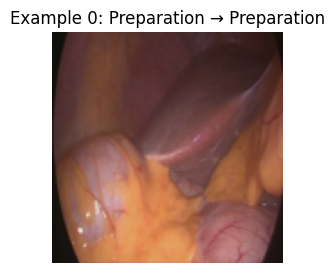

Example 1: true=ClippingCutting, pred=ClippingCutting
  Top tools (unmasked):
    Scissor: 1.000
    Clip-Applicator: 1.000
    HF-Coagulation-Probe: 1.000
    Suction-Rod: 1.000
    Trocar-Tip: 1.000
  Top tools (masked):
    Scissor: 0.000
    Clip-Applicator: 0.000
    Trocar-Tip: 0.000
    Suction-Rod: 0.000
    PE-Forceps: 0.000



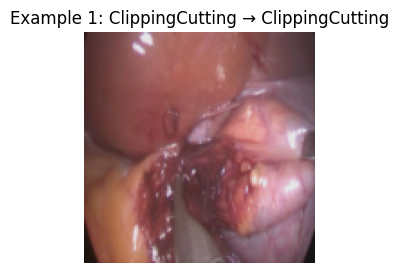

Example 2: true=Preparation, pred=Preparation
  Top tools (unmasked):
    Scissor: 1.000
    HF-Coagulation-Probe: 1.000
    Suction-Rod: 1.000
    Clip-Applicator: 1.000
    Trocar-Tip: 1.000
  Top tools (masked):
    PE-Forceps: 0.769
    Trocar-Tip: 0.000
    Suction-Rod: 0.000
    Scissor: 0.000
    Palpation-Probe: 0.000



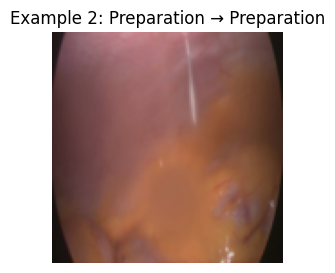

In [7]:
num_examples = 3
examples = []
for i in range(num_examples):
    frames, phase_target, tool_target = val_dataset[i]
    examples.append((frames.unsqueeze(0), phase_target, tool_target))

mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)

for idx, (frames, phase_target, tool_target) in enumerate(examples):
    with torch.no_grad():
        phase_logits, tool_logits = model(frames.to(DEVICE))
        phase_probs = phase_logits.softmax(dim=-1)
        tool_probs = tool_logits.sigmoid()
        masked_logits_ex = apply_phase_mask_to_logits(tool_logits, phase_probs, phase_tool_mask, hard=False)
        masked_probs = masked_logits_ex.sigmoid()
    true_phase_id = phase_target.argmax().item()
    pred_phase_id = phase_probs.argmax(dim=-1).item()
    print(f'Example {idx}: true={ID_TO_PHASE[true_phase_id]}, pred={ID_TO_PHASE[pred_phase_id]}')
    probs = tool_probs.squeeze(0).cpu().numpy()
    mprobs = masked_probs.squeeze(0).cpu().numpy()
    print('  Top tools (unmasked):')
    for i in probs.argsort()[::-1][:5]:
        print(f'    {TOOL_COLUMNS[i]}: {probs[i]:.3f}')
    print('  Top tools (masked):')
    for i in mprobs.argsort()[::-1][:5]:
        print(f'    {TOOL_COLUMNS[i]}: {mprobs[i]:.3f}')
    print()

    # Show the center frame for this example
    frames_unnorm = frames * std + mean
    center = frames_unnorm[0, frames_unnorm.shape[1] // 2]  # (C, H, W)
    img = center.permute(1, 2, 0).clamp(0, 1).cpu().numpy()
    plt.figure(figsize=(3, 3))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Example {idx}: {ID_TO_PHASE[true_phase_id]} → {ID_TO_PHASE[pred_phase_id]}')
    plt.show()